# 1. Test dataset 시각화
- x: 손 좌표 (차원: 42 (21x2))
    - -1~1까지 정규화
    - 0번 index는 (0.0, 0.0)으로 고정, 나머지는 0번 좌표의 상대 좌표
- y: label      (차원: 1 (0-9 범위를 가짐))
    - 0: 보자기
    - 1: 주먹
    - 2: 검지만 핀 것
    - 3: ok sign
    - 4: 브이 (엄지와 검지로 만듬, 검지가 오른쪽)
    - 5: 브이 (엄지와 검지로 만듬, 검지가 왼쪽)
    - 6: 검지를 살짝 구부린 것
    - 7: 엄지만 구부리기
    - 8: 엄지와 중지를 핀 것
    - 9: 엄지만 핀 것 

In [ ]:
import pandas as pd
import numpy as np
import os

# Test dataset load

test_dataset_path = 'model/keypoint_classifier/test_keypoint.csv'


x_test_dataset = np.loadtxt(test_dataset_path,delimiter=',',dtype='float32',usecols=list(range(1,(21*2)+1)))
x_test_dataset = x_test_dataset.reshape(-1,21,2) # shape -> (n, 21, 2)/ n개의 21개의 keypoint들의 x,y 좌표

y_test_dataset = np.loadtxt(test_dataset_path,delimiter=',',dtype='float32',usecols=(0)) # shape -> (n,)/ n개의 label

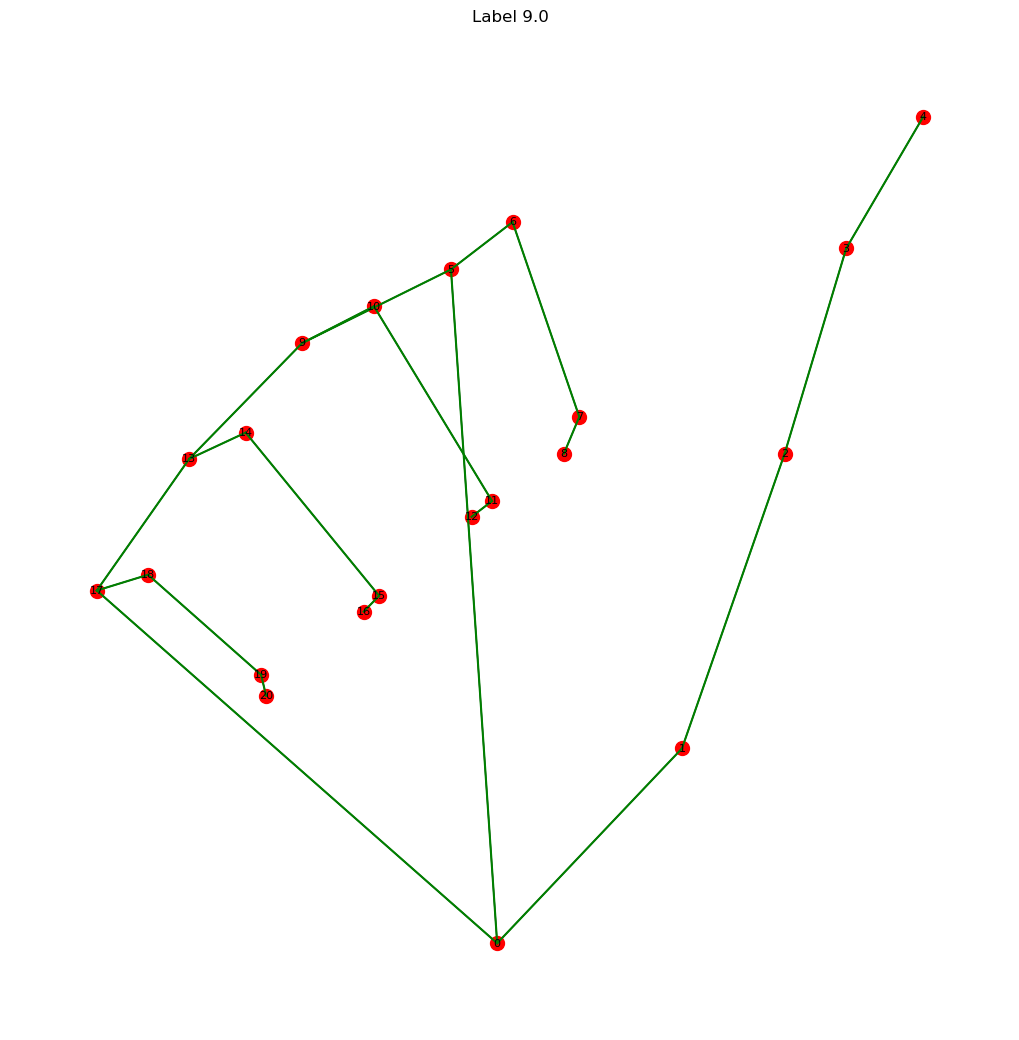

In [ ]:
# 각 data의 plot으로 시각화

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

idx = 3001 # 몇번째 데이터를 볼지 정하기

# 테스트 데이터셋의 첫 번째 이미지의 x, y 좌표를 추출
x = x_test_dataset[idx][:,0]
y = x_test_dataset[idx][:,1]

label = y_test_dataset[idx]

# 그래프 생성
G = nx.Graph()

# 노드 추가
nodes = list(range(21))
G.add_nodes_from(nodes)

# 엣지 추가
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), # 엄지
    (5, 9), (5, 6), (6, 7), (7, 8), # 검지
    (9, 13), (9, 10), (10, 11), (11, 12), # 중지
    (13, 17), (13, 14), (14, 15), (15, 16), # 약지
    (0, 17), (17, 18), (18, 19), (19, 20) # 소지
]
G.add_edges_from(edges)

# 그래프 그리기
plt.figure(figsize=(10, 10))
nx.draw(G, pos=dict(zip(nodes, zip(x, y))), with_labels=True, node_color='red', node_size=100, font_size=8)

# 엣지 그리기
for edge in edges:
    plt.plot([x[edge[0]], x[edge[1]]], [y[edge[0]], y[edge[1]]], 'g-')

plt.title(f'Label {label}')
plt.gca().invert_yaxis()
plt.axis('off')
plt.show()


# 2. 기존 모델 평가

In [1]:
import numpy as np
import torch
import torch.nn as nn
from model.keypoint_classifier.model import KeyPointClassifier

# model load
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

ckpt_path = 'model/keypoint_classifier/keypoint_classifier.pt'
model = KeyPointClassifier()           
loss_func = nn.NLLLoss() 

checkpoint = torch.load(ckpt_path, map_location=lambda storage, loc: storage)
model.load_state_dict(checkpoint)
model.to(device)
model.eval()

c:\Users\cvip\anaconda3\envs\dnn\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


mark: basic classifier on
mark: basic init done


KeyPointClassifier(
  (dropout_input): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=42, out_features=20, bias=True)
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=10, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [2]:
# test dataset을 이용한 모델 평가

import torch
import torch.nn as nn
import torch.nn.functional as F     
import torch.optim as optim

from torch.utils.data import TensorDataset # 텐서 데이터셋
from torch.utils.data import DataLoader # 데이터로더

#csv이용을 위한 라이브러리들
import numpy as np
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm


Batch_size = 128
# test set load
test_dataset_path = 'model/keypoint_classifier/test_keypoint.csv' # test dataset load
x_test_dataset = np.loadtxt(test_dataset_path,delimiter=',',dtype='float32',usecols=list(range(1,(21*2)+1)))
y_test_dataset = np.loadtxt(test_dataset_path,delimiter=',',dtype='float32',usecols=(0))

# 텐서로 변환
x_data_tensor = torch.tensor(x_test_dataset).to(device)
y_data_tensor = torch.tensor(y_test_dataset).to(device)

test_dataset = TensorDataset(x_data_tensor,y_data_tensor)

test_loader = DataLoader(test_dataset,batch_size=Batch_size,shuffle = False)

all_predictions=[]
all_labels = []

with torch.no_grad():
    for batch_x,batch_y in tqdm(test_loader):
        outputs = model(batch_x)
        predictions = outputs.argmax(dim=1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())
        

print('Classification result')
print(classification_report(all_labels,all_predictions))

100%|██████████| 24/24 [00:01<00:00, 14.32it/s]

Classification result
              precision    recall  f1-score   support

         0.0       0.50      0.94      0.66       301
         1.0       0.93      0.97      0.95       300
         2.0       0.51      0.99      0.67       300
         3.0       0.85      0.97      0.91       301
         4.0       0.64      0.96      0.77       300
         5.0       0.59      1.00      0.74       300
         6.0       0.95      0.13      0.22       299
         7.0       1.00      0.01      0.01       324
         8.0       0.93      0.38      0.54       290
         9.0       0.93      0.29      0.44       306

    accuracy                           0.66      3021
   macro avg       0.78      0.66      0.59      3021
weighted avg       0.78      0.66      0.59      3021



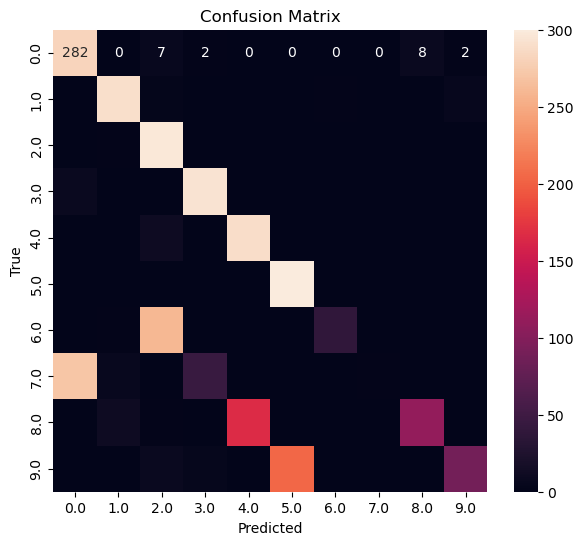

     0.0  1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  9.0
0.0  282    0    7    2    0    0    0    0    8    2
1.0    0  290    3    0    0    0    2    0    0    5
2.0    0    2  297    0    0    1    0    0    0    0
3.0    8    0    0  293    0    0    0    0    0    0
4.0    0    0   11    0  289    0    0    0    0    0
5.0    0    0    0    0    0  300    0    0    0    0
6.0    0    2  259    0    0    0   38    0    0    0
7.0  270    7    0   45    0    0    0    2    0    0
8.0    0   11    2    0  166    0    0    0  111    0
9.0    0    0    8    4    0  205    0    0    0   89


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# confusion matrix로 모델 평가

cm = confusion_matrix(all_labels, all_predictions)
df_cm = pd.DataFrame(cm, index=sorted(set(all_labels)), columns=sorted(set(all_labels)))
plt.figure(figsize=(7,6))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print(df_cm)

In [6]:
import csv
import copy
import argparse
import itertools
from collections import Counter
from collections import deque

import cv2
import numpy as np
import mediapipe as mp

from utils.utils import pre_process_landmark

#pytorch import line
from model.keypoint_classifier.model import KeyPointClassifier

import os
import subprocess 
import torch


# mediapipe hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5,
)


cap = cv2.VideoCapture(0)

while True:
    # Camera capture
    
    ret, img = cap.read()
    if not ret:
        break

    # Convert the image to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img 반전
    img = cv2.flip(img, 1)
    img.flags.writeable = False

    # Detection
    results = hands.process(img)

    # Convert the image back to BGR
    img.flags.writeable = True
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    if results.multi_hand_landmarks is not None:
        for hand_landmarks in results.multi_hand_landmarks:
            # Draw hand landmarks
            mp.solutions.drawing_utils.draw_landmarks(
                img, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # Extract hand keypointsq
            keypoints = np.array([[lmk.x, lmk.y] for lmk in hand_landmarks.landmark]).flatten()
            keypoints = pre_process_landmark(keypoints)
            keypoints_tensor = torch.tensor(keypoints).float().to(device)

            # Prediction
            with torch.no_grad():
                model.eval()
                output = model(keypoints_tensor.unsqueeze(0))
                prediction = output.argmax(dim=1).item()

            # Display prediction
            cv2.putText(img, str(prediction), (int(hand_landmarks.landmark[0].x * img.shape[1]), int(hand_landmarks.landmark[0].y * img.shape[0])), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    cv2.imshow('Hand Gesture Recognition', img)

    if cv2.waitKey(1) == 27:
        break

cap.release()
cv2.destroyAllWindows()